In [1]:
import os
import sys; sys.path.append('../')
import json
import time
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib; matplotlib.style.use('seaborn')
from sklearn.preprocessing import PowerTransformer

import utils


RADIANT_SIDE = [0, 1, 2, 3, 4]
DIRE_SIDE = [128, 129, 130, 131, 132]
FEATURES = utils._typing.property.FEATURES

In [2]:
train_df = pd.read_json(f'../parse/output/public/train_df.json')
val_df = pd.read_json(f'../parse/output/public/val_df.json')
test_df = pd.read_json(f'../parse/output/public/test_df.json')

In [3]:
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)

df = pd.concat([train_df, val_df, test_df], axis=0).reset_index()

In [4]:
with open(r'../scarpe/dotaconstants/build/hero_names.json', 'r') as f:
    hero_json = json.load(f)

id_to_hero = {hero_json[npc]['id']: hero_json[npc]['localized_name'] for npc in hero_json}


players_regression_columns = [f'{_}_{f}' for _ in RADIANT_SIDE + DIRE_SIDE for f in FEATURES]
teams_regression_columns = [f'{_}_{f}' for _ in 'rd' for f in FEATURES]

p_columns = [f'{_}_account_id' for _ in RADIANT_SIDE + DIRE_SIDE]
h_columns = [f'{_}_hero_id' for _ in RADIANT_SIDE + DIRE_SIDE]
r_columns = [f'{_}_hero_role' for _ in RADIANT_SIDE + DIRE_SIDE]
l_columns = [f'{_}_lane_role' for _ in RADIANT_SIDE + DIRE_SIDE]
t_columns = [f'{_}_rank_tier' for _ in RADIANT_SIDE + DIRE_SIDE]

In [5]:
# Inputs
t_arr = df[t_columns].values.astype('int64')
h_arr = df[h_columns].values.astype('int64')
p_arr = df[p_columns].values.astype('int64')

# Global inputs
# None


# Players outputs
r_arr = df[r_columns].values.astype('int64')
l_arr = df[l_columns].values.astype('int64') - 1

num = len(players_regression_columns)//10
players_regression_arr = df[players_regression_columns].values.astype('float32')
players_regression_arr = np.concatenate(
    [players_regression_arr[:, None, i*num:num*(i+1)] for i in range(10)], 
    axis=1
)

# Teams outputs
num = len(teams_regression_columns)//2
teams_regression_arr = df[teams_regression_columns].values.astype('float32')
teams_regression_arr = np.concatenate(
    [teams_regression_arr[:, None, i*num:num*(i+1)] for i in range(2)], 
    axis=1
)

win_arr = df['radiant_win'].values
win_arr = np.concatenate([win_arr[:, None], ~win_arr[:, None]], axis=-1).astype('float32')
duration_arr = df['duration'].values.astype('float32')
duration_arr = np.concatenate([duration_arr[:, None], duration_arr[:, None]], axis=-1).astype('float32')

# Others
matchIDArr = df['match_id'].values.astype('int64')

In [6]:
flattenHeroesArr = h_arr.flatten()
setHeroesArr = set(flattenHeroesArr)
playedGamesH = {p:0 for p in setHeroesArr}
for p in flattenHeroesArr:
    playedGamesH[p] += 1

heroesPlayedGames = pd.DataFrame(
    data = list(playedGamesH.values()),
    index = list(id_to_hero.values()),
    columns = ['played_games']
)

fig, ax = plt.subplots(1, 1, figsize=(25, 25))
sns.barplot(
    x=heroesPlayedGames['played_games'], 
    y=heroesPlayedGames.index, 
    palette="Blues_d",
    ax=ax,
)

fig.savefig('output/heroes_pickrate', bbox_inches='tight')
plt.close(fig)

In [7]:
indexex = np.arange(0, len(df))
test_indecxes = indexex[-test_size:]
val_indexes   = indexex[-(test_size+val_size):-test_size]
train_indexes = indexex[:-(test_size+val_size)]

In [8]:
# --------------------------------------- #
Ytrain = [
    # players_regression_arr[train_indexes],
    # l_arr[train_indexes],
    # r_arr[train_indexes],
    
    teams_regression_arr[train_indexes],
    win_arr[train_indexes],
    # duration_arr[train_indexes],
    # np.concatenate([win_arr[:, None], win_arr[:, None]*-1+1], axis=1)[train_indexes],
]
# Ytrain = win_arr[train_indexes]
Xtrain = [
    h_arr[train_indexes],
    p_arr[train_indexes],
    t_arr[train_indexes],
]
# --------------------------------------- #
Yval = [
    # players_regression_arr[val_indexes],
    # l_arr[val_indexes],
    # r_arr[val_indexes],
    
    teams_regression_arr[val_indexes],
    win_arr[val_indexes],
    # duration_arr[val_indexes],
    # np.concatenate([win_arr[:, None], win_arr[:, None]*-1+1], axis=1)[val_indexes],
]
# Yval = win_arr[val_indexes]
Xval = [
    h_arr[val_indexes],
    p_arr[val_indexes],
    t_arr[val_indexes],
]
# --------------------------------------- #
Ytest = [
    # players_regression_arr[test_indecxes],
    # l_arr[test_indecxes],
    # r_arr[test_indecxes],
    
    teams_regression_arr[test_indecxes],
    win_arr[test_indecxes],
    # duration_arr[test_indecxes],
    # np.concatenate([win_arr[:, None], win_arr[:, None]*-1+1], axis=1)[test_indecxes],
]
# Ytest = win_arr[test_indecxes]
Xtest = [
    h_arr[test_indecxes],
    p_arr[test_indecxes],
    t_arr[test_indecxes],
]

# MODEL PART

In [9]:
import datetime

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Input
from sklearn import metrics

from transformers import AdamWeightDecay 

#### inf

In [10]:
def inf(y_true, y_pred, window = 0.05):
    import seaborn as sns
    from sklearn import metrics
    from matplotlib import pyplot as plt
    
    
    assert len(y_true) == len(y_pred), 'y_true != y_pred'

    try:
        y_true = y_true[:, 0]
    except:
        pass
    try:
        y_pred = y_pred[:, 0]
    except:
        pass
    
    def accuracy(y_true, y_pred):
        return 1 - np.abs(np.round(y_pred) - y_true).sum()/len(y_true)


    def delta_probability_mean_score(y_true, y_pred, d1, d2):
        """ Calculate probability_mean_score in window from d1 to d2
        for example:
            d1 = 0.
            d2 = 0.5
        this will calculate probability_mean_score from this window (probability_mean_score for 0 label)
        """
        if d2 < d1:
            d2, d1 = d1, d2
        arr = y_true[(y_pred >= d1) & (y_pred <= d2)] - y_pred[(y_pred >= d1) & (y_pred <= d2)]
        return (arr.sum()/len(arr))*100


    def delta_accuracy(y_true, y_pred, d1, d2):    
        if d2 < d1:
            d2, d1 = d1, d2
        y_true, y_pred = y_true[(y_pred >= d1) & (y_pred <= d2)], y_pred[(y_pred >= d1) & (y_pred <= d2)]

        if len(y_pred) == 0:
            return None, None
        else:
            return accuracy(y_true, y_pred), len(y_pred)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fpr, tpr, threshold = metrics.roc_curve(y_true,  y_pred)
    auc = metrics.roc_auc_score(y_true, y_pred)
    print('Balance Y :', round(np.array(y_true).sum()/len(y_true), 3))
    print('Accuracy  :', round(accuracy(y_true, y_pred), 3))
    print('Precision :', round(metrics.precision_score(y_true, np.around(y_pred)), 3))
    print('Recall    :', round(metrics.recall_score(y_true, np.around(y_pred)), 3))
    print('AUC       :', round(auc, 3))
    print()
    print('Confusion matrix')
    print(metrics.confusion_matrix(y_true, np.around(y_pred)))
    print()
    

    sns.histplot(y_pred, bins = 100, ax = axes[0])
    axes[1].plot(fpr,tpr,label="data 1, auc="+str(auc))
    axes[1].legend(loc=4)
    
    best_model = pd.DataFrame()
    delta = np.arange(0., 1.0, window)
    # we will collect abs score in this list, then we calculate average score 
    abs_score_list = []
    
    pred_len = len(y_pred)
    for d in delta:
        acc, samples = delta_accuracy(y_true, y_pred, d, d + window)
        if samples != None:
            score = round(delta_probability_mean_score(y_true, y_pred, d, d + window), 1)

            if d < 0.5:
                column = f"{int(100 - round(d, 2)*100)}% - {int(100 - round(d+window, 2)*100)} %"
            else:
                column = f"{int(round(d, 2)*100)}% - {int(round(d+window, 2)*100)} %"

            best_model.loc['Accuracy', column] = str(round(acc*100, 2)) + ' %'
            best_model.loc['Mean porabalistic error', column] = str(round(score, 3))
            best_model.loc['Samples%', column] = str(int(samples*100/pred_len)) 
            best_model.loc['Samples', column] = str(samples)


            abs_score_list.append(abs(score))

    print(f"Abs probability_mean_score per windows: {round(np.array(abs_score_list).mean(), 3)}")
    print('Number of predictions :', pred_len)
    print()
    
    display(best_model)
    plt.show()

#### CustomMetricCheckpoint

In [11]:
class CustomCheckpoint(keras.callbacks.Callback):
    def __init__(self, board_name, monitor, mode, path):
        super(CustomCheckpoint, self).__init__()
        self.board_name = board_name
        self.monitor = monitor
        self.mode = mode
        self.path = path
        
        self.best = -np.inf if mode == 'max' else np.inf

        
    def on_epoch_end(self, epoch, logs=None):
        l = logs.get(self.monitor)
        if self.mode == 'max':
            if l > self.best:
                self.best = l
                self.model.save(self.path + self.board_name + f'_{self.monitor}.h5')
                
        if self.mode == 'max':
            if l < self.best:
                self.best = l
                self.model.save(self.path + self.board_name + f'_{self.monitor}.h5')

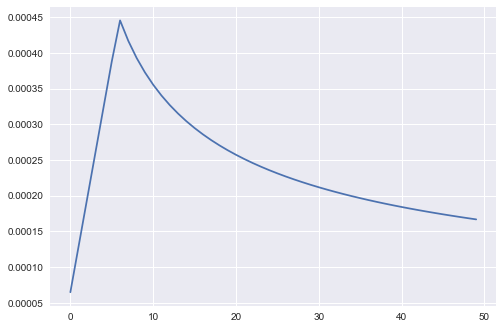

In [12]:
def scheduler(step):
    step+=1
    arg1 = np.reciprocal(np.sqrt(step))
    arg2 = step * (14 ** -1.1)
    value = (np.reciprocal(np.sqrt(18)) * np.minimum(arg1, arg2)) * 5e-3
    return value

lr_schedule = keras.callbacks.LearningRateScheduler(scheduler)
epochs = [scheduler(x) for x in range(50)]
plt.plot(epochs)

### TransformerBlock

In [13]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.15, name = None, **kwargs):
        super(TransformerBlock, self).__init__(name=name)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        
        self.att = keras.layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embed_dim)
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(self.ff_dim, activation = 'gelu'),
                keras.layers.Dropout(self.rate),
                keras.layers.Dense(self.embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)

        
    def call(self, inputs, training=None):
        attn_output = self.att(
            query=inputs, 
            value=inputs, 
            key=inputs,
        )
        norm1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(norm1, training=training)
        norm2 = self.layernorm2(norm1 + ffn_output)
        return norm2
    
    
    def get_config(self):
        config = {'embed_dim': self.embed_dim,
                  'num_heads': self.num_heads,
                  'ff_dim'   : self.ff_dim,
                  'rate'     : self.rate}
        return config

### AttentionBlock

In [14]:
class AttentionBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.15, name = None, **kwargs):
        super(AttentionBlock, self).__init__(name=name)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        
        self.layernorm = keras.layers.LayerNormalization(epsilon=1e-6)
        self.att = keras.layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embed_dim)
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(self.ff_dim, activation = 'gelu'),
                keras.layers.Dropout(self.rate),
                keras.layers.Dense(self.embed_dim),
            ]
        )

        
    def call(self, radiant, dire, training=None):
        radiant_ = self.att(
            query=radiant,
            value=dire,
            key=dire,
        )
        dire_ = self.att(
            query=dire,
            value=radiant,
            key=radiant,
        )
        
        radiant = self.ffn(radiant_) + radiant
        dire = self.ffn(dire_) + dire
        
        radiant = self.layernorm(radiant)
        dire = self.layernorm(dire)
        
        return radiant, dire
    
    
    def get_config(self):
        config = {'embed_dim': self.embed_dim,
                  'num_heads': self.num_heads,
                  'ff_dim'   : self.ff_dim,
                  'rate'     : self.rate}
        return config

### EmbBlock

In [15]:
class EmbBlock(keras.layers.Layer):
    def __init__(self, in_dim, out_dim, name=None, **kwargs):
        super(EmbBlock, self).__init__(name=name)
        self.in_dim  = in_dim
        self.out_dim = out_dim       
        
        self.positions = tf.cast([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]], dtype='int32')
        
        self.ranks_emb = keras.layers.Embedding(10, self.in_dim)
        self.pos_emb   = keras.layers.Embedding(2, self.in_dim)
        
        self.ffn_layer = keras.layers.Dense(self.in_dim)
        self.dropout   = keras.layers.Dropout(0.2)
        self.layer     = keras.layers.Dense(self.out_dim, activation = 'gelu')
        
    def call(self, players, heroes, ranks, training=None):
        pos = self.pos_emb(self.positions)
        pos = tf.repeat(pos, tf.shape(players)[0], axis = 0)
        
        ranks_r = ranks[:, :5]//10
        ranks_d = ranks[:, 5:]//10    
        ranks_r = self.ranks_emb(ranks_r)
        ranks_d = self.ranks_emb(ranks_d)
        ranks = tf.concat([ranks_r, ranks_d], axis=1)
        
    
        x = self.ffn_layer(
            tf.concat([players, heroes], axis=-1)
        )
        x = x + ranks + pos
        x = self.layer(x)
        
        radiant, dire = x[:, :5], x[:, 5:]
        return radiant, dire
    
    def get_config(self):
        config = {'in_dim': self.in_dim,
                  'out_dim': self.out_dim}
        return config

### Masking

In [16]:
class Masking(keras.layers.Layer):
    def __init__(self, rate=0.01, name=None, **kwargs):
        super(Masking, self).__init__(name=name)
        self.rate  = rate
        
    def call(self, x, training=None):
        if training and self.trainable:
            # > rate cause tf.where works stupid
            inp_mask = tf.random.uniform(tf.shape(x)) > self.rate
            x = tf.where(inp_mask, x, 0)
        return x
    
    def get_config(self):
        return {'rate': self.rate}

### Model

In [17]:
custom_objects = {
    'Masking': Masking,
    'EmbBlock': EmbBlock,
    'TransformerBlock': TransformerBlock,
    'AttentionBlock': AttentionBlock,
}

In [18]:
(p_arr.max()+1)**0.5, (h_arr.max()+1)**0.5

(25.573423705088842, 11.74734012447073)

In [72]:
K.clear_session()

d_model = 64
ff_dim = 128
num_heads = 8
layer_num = 8
dropout = 0.1

hero_input   = Input(10, name='hero_input')
player_input = Input(10, name='player_input')
rank_input   = Input(10, name='rank_input')
imputs = [hero_input, player_input, rank_input]

# --------------------------------------- #
masking = Masking(0.01)

hEmbeddibg = keras.layers.Embedding(h_arr.max()+1, 16, name='heroes_embedding')
pEmbeddibg = keras.layers.Embedding(p_arr.max()+1, 24, name='players_embedding')

embBlock = EmbBlock(in_dim=d_model, out_dim=d_model, name='EmbBlock')

# tBlock1  = TransformerBlock(embed_dim=d_model, num_heads=num_heads, ff_dim=ff_dim, rate=dropout, name='transformerBlock1')
# aBlock1  = AttentionBlock(embed_dim=d_model, num_heads=num_heads, ff_dim=ff_dim, rate=dropout, name='attentionBlock1')

# tBlock2  = TransformerBlock(embed_dim=d_model, num_heads=num_heads, ff_dim=ff_dim, rate=dropout, name='transformerBlock2')
# aBlock2  = AttentionBlock(embed_dim=d_model, num_heads=num_heads, ff_dim=ff_dim, rate=dropout, name='attentionBlock2')

# tBlock3  = TransformerBlock(embed_dim=d_model, num_heads=num_heads, ff_dim=ff_dim, rate=dropout, name='transformerBlock3')
# aBlock3  = AttentionBlock(embed_dim=d_model, num_heads=num_heads, ff_dim=ff_dim, rate=dropout, name='attentionBlock3')

# tBlock4  = TransformerBlock(embed_dim=d_model, num_heads=num_heads, ff_dim=ff_dim, rate=dropout, name='transformerBlock4')
# aBlock4  = AttentionBlock(embed_dim=d_model, num_heads=num_heads, ff_dim=ff_dim, rate=dropout, name='attentionBlock4')

# --------------------------------------- #
players_ffn = keras.Sequential([
    keras.layers.Dense(d_model, activation = 'gelu'),
    keras.layers.Dropout(dropout),
    keras.layers.Dense(d_model, activation = 'gelu'),
    keras.layers.Dropout(dropout),
])
teams_ffn = keras.Sequential([
    keras.layers.Dense(d_model*2, activation = 'gelu'),
    keras.layers.Dropout(dropout),
    keras.layers.Dense(d_model, activation = 'gelu'),
])
win_ffn = keras.Sequential([
    keras.layers.Dense(d_model*2, activation = 'gelu'),
    keras.layers.Dropout(dropout),
    keras.layers.Dense(d_model, activation = 'gelu'),
    keras.layers.Dense(1),
])


hero_input = masking(hero_input)
p = pEmbeddibg(player_input)
h = hEmbeddibg(hero_input)

r, d = embBlock(p, h, rank_input)
#  |r, d| -> (batch, 5, embed_dim), (batch, 5, embed_dim)

# --------------------------------------- #
# r_, d_ = tBlock1(r), tBlock1(d)
# r, d = aBlock1(r_, d_)

# r, d = tBlock2(r), tBlock2(d)
# r, d = aBlock2(r, d)

# r, d = tBlock3(r), tBlock3(d)
# r, d = r + r_, d + d_
# r, d = aBlock3(r, d)

# r, d = tBlock4(r), tBlock4(d)

# --------------------------------------- #
# _r, _d = None, None
# for i in range(layer_num):
#     self_attention = TransformerBlock(embed_dim=d_model, num_heads=num_heads, ff_dim=ff_dim, name=f'self_attention_block{i}')
#     cross_attenrion = AttentionBlock(embed_dim=d_model, num_heads=num_heads, ff_dim=ff_dim, name=f'cross_attention_block{i}')
    
#     if i%2 == 0:
#         if _r is not None and _d is not None:
#             r, d = r + _r, d + _d
            
#         _r, _d = self_attention(r), self_attention(d)
#         _r, _d = cross_attenrion(_r, _d)
#         r, d = _r, _d
#     else:
#         r, d = self_attention(r), self_attention(d)
#         r, d = cross_attenrion(r, d)
    
# --------------------------------------- #
# players = tf.concat([r, d], axis=1)
# for i in range(layer_num):
#     self_attention = TransformerBlock(embed_dim=d_model, num_heads=num_heads, ff_dim=ff_dim, name=f'self_attention_block{i}')
#     players = self_attention(players)
    
# r, d = players[:, :5, :], players[:, 5:, :]

# --------------------------------------- #
players = tf.concat([r, d], axis=1)
players_ = None
for i in range(layer_num):
    self_attention = TransformerBlock(embed_dim=d_model, num_heads=num_heads, ff_dim=ff_dim, name=f'self_attention_block{i}')
    
    if i%4 == 0:
        if players_ is not None:
            players = players + players_
            
        players_ = self_attention(players)
        players = players_
    else:
        players = self_attention(players)
        
r, d = players[:, :5, :], players[:, 5:, :]

# --------------------------------------- #
# Concat and apply player_ffn for each player 
# [batch, 5, embed_dim], [batch, 5, embed_dim] -> [batch, 10, embed_dim]
# players = players_ffn(tf.concat([r, d], axis=1))

# [batch, 5, embed_dim], [batch, 5, embed_dim] -> [batch, embed_dim], [batch, embed_dim]
team1, team2 = tf.reduce_mean(r, axis=1), tf.reduce_mean(d, axis=1) 
teams = tf.concat([
    team1[:, tf.newaxis],
    team2[:, tf.newaxis]
    ], axis=1)

teams = teams_ffn(teams)
team1 = win_ffn(team1)
team2 = win_ffn(team2)

# --------------------------------------- #
# For each player
# players_regression_output = keras.layers.Dense(players_regression_arr.shape[-1], name='players_regression_output')
# l_output = keras.layers.Dense(4, activation='softmax', name='l_output') # SparseCategoricalCrossentropy  
# r_output = keras.layers.Dense(5, activation='softmax', name='r_output') # SparseCategoricalCrossentropy  

# For each team
teams_regression_output = keras.layers.Dense(teams_regression_arr.shape[-1], name='teams_regression_output') 
# duration_output = keras.layers.Dense(1, name='duration_output') 
# win_output = keras.layers.Dense(2, activation='softmax', name='win_output')  
win_output = keras.layers.Softmax(name='win_output')


outputs = [
    # players_regression_output(players), 
    # l_output(players), 
    # r_output(players), 
    
    teams_regression_output(teams),
    # duration_output(teams),
    win_output(tf.concat([team1, team2], axis=1)),
]

# --------------------------------------- #
model = keras.Model(
    inputs=imputs,
    outputs=outputs, 
)

pred = model.predict([x[-400:] for x in Xtrain])

model.save(f"test.h5")
model = keras.models.load_model(f'test.h5', compile=False, custom_objects=custom_objects)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 hero_input (InputLayer)        [(None, 10)]         0           []                               
                                                                                                  
 player_input (InputLayer)      [(None, 10)]         0           []                               
                                                                                                  
 masking_1 (Masking)            (None, 10)           0           ['hero_input[0][0]']             
                                                                                                  
 players_embedding (Embedding)  (None, 10, 24)       15696       ['player_input[0][0]']           
                                                                                              

In [73]:
# optimizer = tfa.optimizers.AdamW(weight_decay=0.02, learning_rate=3e-4, epsilon=1e-6, clipvalue=1.5)
optimizer = AdamWeightDecay(learning_rate=3e-4, weight_decay_rate=0.2, epsilon=1e-6, clipvalue=1.5)

model.compile(
    optimizer=optimizer,
    loss={
        # 'players_regression_output': tf.keras.losses.MeanSquaredError(),
        # 'l_output': tf.keras.losses.SparseCategoricalCrossentropy(),
        # 'r_output': tf.keras.losses.SparseCategoricalCrossentropy(),
        
        'teams_regression_output': tf.keras.losses.MeanSquaredError(),
        # 'duration_output': tf.keras.losses.MeanSquaredError(),
        'win_output': tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    },
    loss_weights={
        # 'players_regression_output': 1.,
        # 'l_output': 0.1,
        # 'r_output': 0.1,
        
        'teams_regression_output': 1.5,
        # 'duration_output': 0.25,
        'win_output': .0,
    },
    metrics={
        # 'players_regression_output': ['mae', 'mean_absolute_percentage_error', ],
        # 'l_output': ['accuracy', ],
        # 'r_output': ['accuracy', ],
        
        'teams_regression_output': ['mae', 'mse', ],
        # 'duration_output': ['mae', ],
        'win_output': ['accuracy', keras.metrics.AUC(num_thresholds=60, name='auc')],
    }, 
)

board_name = datetime.datetime.now().strftime("%Y-%m-%d - %H-%M-%S")
log_dir = f"logs/fit/public/params-{model.count_params()} --- data-{board_name}"

monitor = "val_teams_regression_output_mse" # "val_win_output_auc" 
try:
    with tf.device('/gpu:0'):
        tb = keras.callbacks.TensorBoard(log_dir=log_dir),
        es = keras.callbacks.EarlyStopping(monitor=monitor, mode='min', patience=25, restore_best_weights=True),
        cc = CustomCheckpoint(board_name, monitor=monitor, mode='min', path='CustomCallbackCheckpoints/')
        model.fit(
            Xtrain, Ytrain,
            validation_data=(Xval, Yval),
            callbacks=[lr_schedule, es, tb, cc],
            verbose=0,
            epochs=10**8,
            batch_size=1024*2,
            shuffle=True,
            # sample_weight=np.arange(0.5, 1, 0.5/len(train_indexes)),
        )
except KeyboardInterrupt:
    pass

In [76]:
pred = model.predict(Xtest)

In [69]:
accuracy = metrics.accuracy_score(Ytest[1][:, 0], pred[1][:, 0].round())
auc = metrics.roc_auc_score(Ytest[1][:, 0], pred[1][:, 0])
log_loss = metrics.log_loss(Ytest[1][:, 0], pred[1][:, 0])
precision = metrics.precision_score(Ytest[1][:, 0], pred[1][:, 0].round())
recall = metrics.recall_score(Ytest[1][:, 0], pred[1][:, 0].round())

accuracy, auc, log_loss, precision, recall

(0.5349479498619077,
 0.551639464160593,
 0.6903785296324233,
 0.5220897615708275,
 0.6431965442764579)

In [77]:
def reg_sort(true, pred):
    idxs = np.argsort(true)
    return true[idxs], pred[idxs]

def plot_features(true: np.ndarray, pred: np.ndarray, ncols=6, increase_factor=3, title=''):
    imgs_num = len(FEATURES)
    nrows = imgs_num//ncols + int(imgs_num%ncols > 0)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*increase_factor, nrows*increase_factor))
    fig.suptitle(title, fontsize=4*increase_factor)

    for ax, f, feature in zip(axes.flatten(), range(imgs_num), FEATURES):
        t, p = true[:, :, f].flatten(), pred[:, :, f].flatten()
        t, p = reg_sort(t, p)
        
        ax.set_title(feature)
        ax.plot(p, label='pred', alpha=0.6)
        ax.plot(t, label='true', alpha=1.0)
        
        ax.legend()
        
    plt.show()

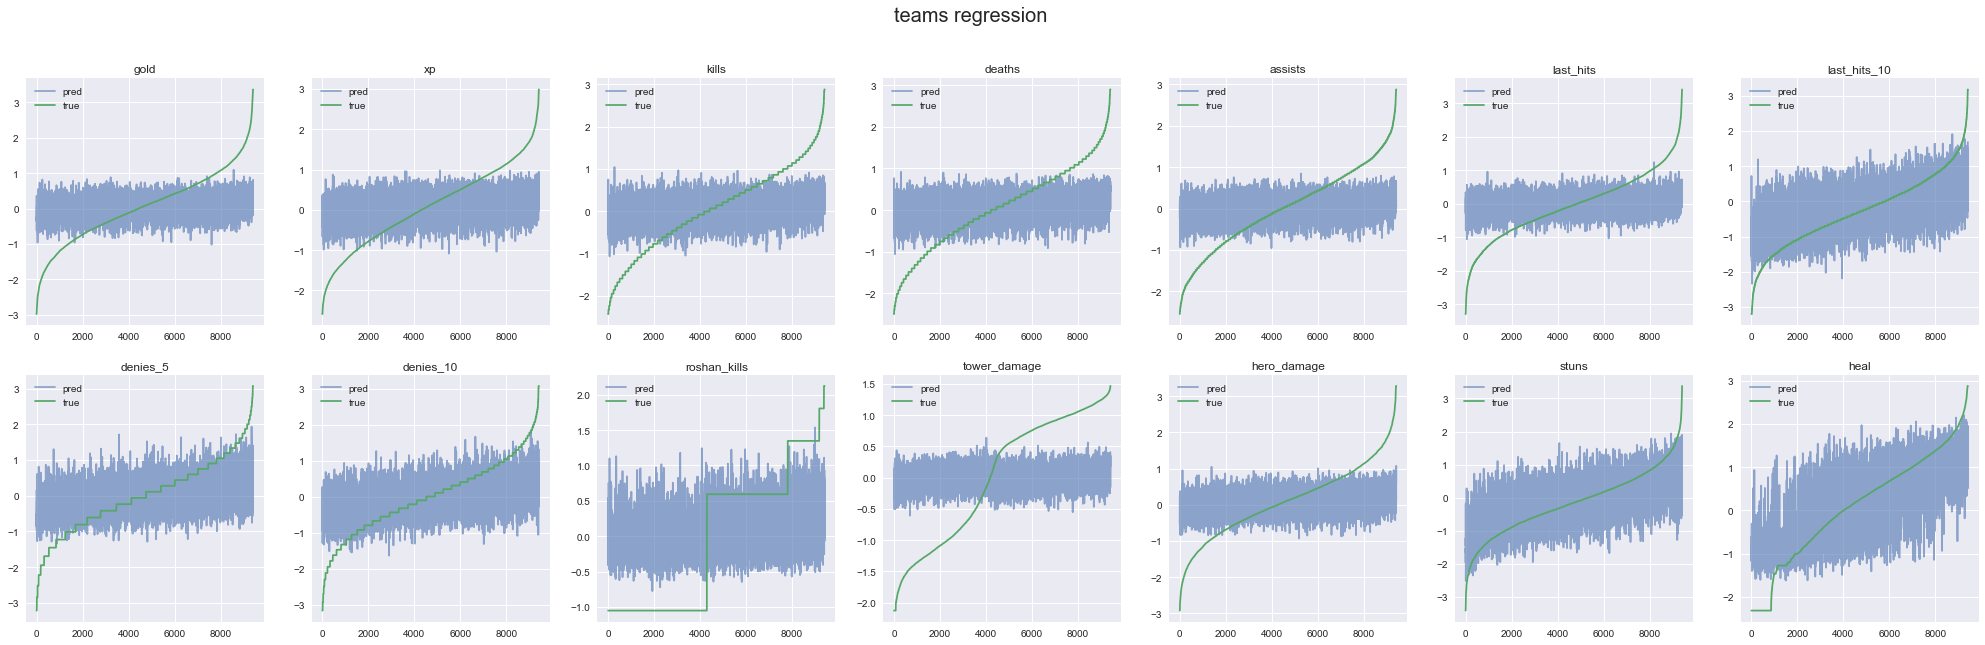

In [78]:
plot_features(Ytest[0], pred[0], ncols=7, increase_factor=5, title='teams regression')

In [79]:
id_to_hero[0] = 'SPECIAL TOKEN'
heroes_ids = set(h_arr.flatten())
ids = np.array([0] + list(heroes_ids))

emb_layer = model.get_layer('heroes_embedding')
W = emb_layer.get_weights()[0]
W.shape

(138, 16)

In [80]:
np.save('output/embeddings/heroes_embeddings', W)

In [81]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [83]:
tsne = TSNE(
    n_components=2, 
    perplexity=64, 
    early_exaggeration=12,
    learning_rate='auto',
    random_state=69,
    init='random',
)

embed = tsne.fit_transform(W[ids])
x_, y_ = embed[:, 0], embed[:, 1]
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
sns.scatterplot(x_, y_, ax=ax)
ax.axhline(0, c='black', alpha=0.25)
ax.axvline(0, c='black', alpha=0.25)

for x, y, i in zip(x_, y_, ids):
    ax.text(x-.002, y+.0025, id_to_hero[i])
    
    
fig.savefig('output/embeddings/TSNE_heroes', bbox_inches='tight')
plt.close(fig)

C:\Users\royta\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


In [84]:
pca = PCA(n_components=2, random_state=69)
embed = pca.fit_transform(W[ids])
x_, y_ = embed[:, 0], embed[:, 1]
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
sns.scatterplot(x_, y_, ax=ax)
ax.axhline(0, c='black', alpha=0.25)
ax.axvline(0, c='black', alpha=0.25)

for x, y, i in zip(x_, y_, ids):
    ax.text(x-.002, y+.0025, id_to_hero[i])
    
fig.savefig('output/embeddings/PCA_heroes', bbox_inches='tight')
plt.close(fig)

C:\Users\royta\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
